In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [4]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc




In [6]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [7]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

/var/folders/0d/rbyhbrpx4y35zj7thj223pwc0000gn/T/ipykernel_15585/3601434573.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [8]:
# Print all of the classes mapped to the Base
for class_name in Base.classes.keys():
    print(class_name)

station
measurement


In [9]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create a session
session = Session(engine)

In [11]:
# import sqlite3
# import pandas as pd

# # Step 1: Connect to your SQLite database
# conn = sqlite3.connect('your_database.db')

# # Step 2: Write a query (for example, selecting all rows from a table)
# query = "SELECT * FROM Measurement"

# # Step 3: Use pandas to read the SQL query into a DataFrame
# df = pd.read_sql_query(query, conn)

# # Step 4: Close the database connection
# conn.close()

# # Step 5: Print the DataFrame
# print(df)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

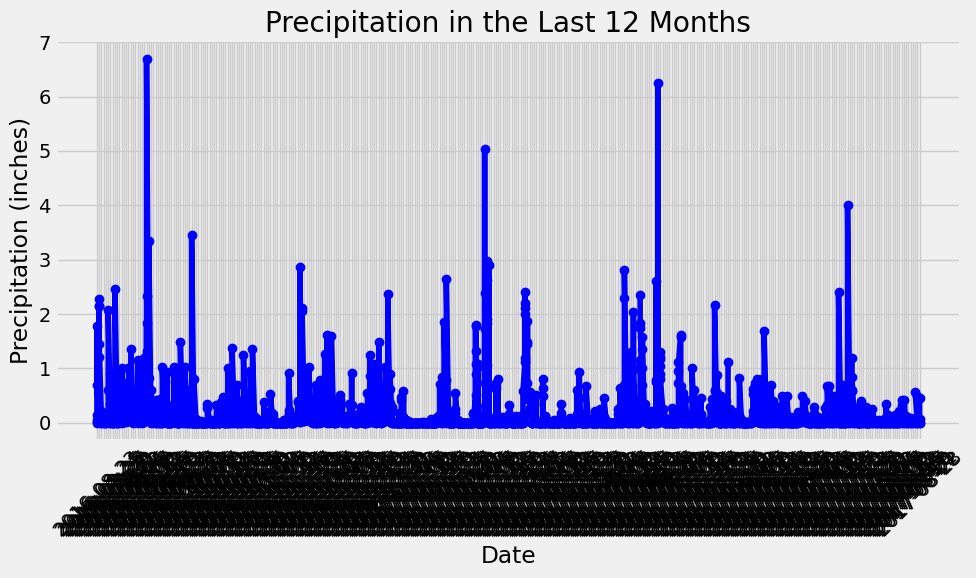

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.


# Calculate the date one year from the last date in data set.
previous_year = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
                            .filter(Measurement.date >= previous_year)\
                            .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])

# Sort the dataframe by date
precipitation_df_sorted = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df['date'], precipitation_df['prcp'], marker='o', linestyle='-', color='b')
plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Measurement.station.distinct())).scalar()
station_count

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Measurement.station, func.count(Measurement.station).label('station_count')
).group_by(Measurement.station).order_by(desc('station_count')).all()

# Print the results
for station, count in active_stations:
    print(station,count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(
    Measurement.station, func.count(Measurement.station).label('station_count')
).group_by(Measurement.station).order_by(desc('station_count')).first()

most_active_station_id = most_active_station.station

temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).first()

temperature_stats

(54.0, 85.0, 71.66378066378067)

Text(0.5, 4.183333333333314, 'Temperature')

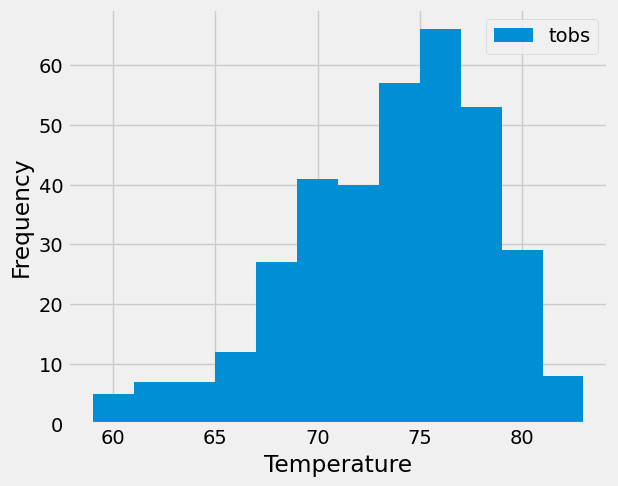

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()
